# wellpathpy prototype

## Goal

To build a light package to load well deviations

## Objectives

1. load well deviation in one of <_n_> formats:
    * meta data (header, rkb, dfe, rt)
    * md, incl, azi
    * mE, mN, depth
    * other ?,?,?
2. interpolate survey using one of these methods:
    * minimum curvature method
    * radius of curvature method
    * tangential method
    * other ?
3. calculate dog-leg severity
4. calculate depth references using header data if available: MD, TVD, TVDSS
5. return interpolated deviation in all <_n_> input formats and in all depth references if possible
6. resample on regular steps

## Sources of equations:

- [petrowiki](https://petrowiki.org/Calculation_methods_for_directional_survey)
- [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)
- [drillingformulas](http://www.drillingformulas.com)

## software _architecture_

(get input from Jørgen: `jokva`)

- code to `list` (will then also accept `nd.array`)
- data reader (chooses files to accept: `*.csv`, `*.xlsx`)
- guess data types if not provided by user?
- library of interpolation functions
- depth calculation function
- deploy to [pypi](https://pypi.org/)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/Well_Surveys_Projected_to_TD.csv', skiprows=4, usecols=['MD[m]',
                                                                                 'Inc[deg]',
                                                                                 'Azi[deg]',
                                                                                 'Dogleg [deg/30m]',
                                                                                 'TVD[m]',
                                                                                 'North[m]',
                                                                                 'East[m]'],
                )
df.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m]
0,0,0.0,0.00,0.00,0.00,0.00,NaN
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17
3,134,0.9,15.59,133.99,1.47,0.30,0.03
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27


In [3]:
df.drop(df.tail(1).index,inplace=True)
df.dropna(inplace=True)
df.to_csv('../data/deviation.csv', index=False)

In [4]:
def read_deviation(fname):
    """
    Read a deviation file into memory for processing
    
    Args:
        filename
        
    Return:
        pd.DataFrame
        
    """
    return pd.read_csv(fname)


In [5]:
read_deviation('../data/deviation.csv').head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12


In [6]:
def get_header(datum='kb', units='m', elevation=0.):
    """
    Record deviation header information needed for depth
    reference calculation into DataFrame.
    
    Parameters
    ----------
    datum: str, default 'kb', {'kb', 'dfe', 'rt'}
           'kb' (kellybushing),
           'dfe' (drill floor elevation),
           'rt' (rotary table)
    units: str, default 'm', {'m', 'ft'}
           'm' (metres),
           'ft' (feet)
    elevation: float, default 0., 
           <datum> <elevation> in <units> 
           above mean sea level
    
    Returns
    -------
    dict
        deviation header dictionnary
    """
    if datum not in {'kb', 'dfe', 'rt'}:
        raise ValueError('datum must be kb, dfe or rt')
    
    if units not in {'m', 'ft'}:
        raise ValueError('units must be m or ft')
 
    try:
        elevation = float(elevation + 0)
    except TypeError:
        raise TypeError('elevation must be float')
        
    return {'datum': datum, 'units': units, 'elevation': elevation}


In [7]:
get_header(datum='kb', units='m', elevation=12)

{'datum': 'kb', 'units': 'm', 'elevation': 12.0}

In [8]:
def mdtotvd(deviation, method='mincurv'):
    """
    Calculate TVD from given method.
    
    Parameters
    ----------
    deviation: DataFrame in MD, incl, azi
    method: str, default 'tangential', {'tan', 'avtan', 'baltan', 'merc', 'radcurv', 'mincurv'}
            'tan' (tangential method),  'avtan' (average tangential method),
            'baltan' (balanced tangential method), 'merc' (mercury method),
            'radcurv' (radius of curvature method), 'mincurv' (minimum curvature method)
            method definitions: [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)
            
    Returns
    -------
    DataFrame
        deviation survey converted to TVD, easting, northing
        
    To Do
    -----
    implement methods
            
    """

    return deviation

Source:  [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)

Definitions:
  - East = easterly displacement (feet or meters) - negative = West
  - HAZ1 = hole azimuth at top of course (degrees)
  - HAZ2 = hole azimuth at bottom of course (degrees)
  - MD1 = measured depth at top of course (feet or meters)
  - MD2 = measured depth at bottom of course (feet or meters)
  - North = northerly displacement (feet or meters) - negative = South
  - TVD = true vertical depth (feet or meters)
  - WD1 = well deviation at top of course (degrees)
  - WD2 = well deviation at bottom of course (degrees)

The minimum curvature method, like the radius of curvature method, takes the space vectors defined by inclination and direction measurements and smoothes these onto the wellbore curve by the use of a ratio factor which is defined by the curvature (dog-leg) of the wellbore section. The method produces a circular arc as does the radius of the curvature. This is not, however, an assumption of the method, but a result of minimizing the total curvature within the physical constraints on a section of wellbore.

      1: DL = Arccos (Cos (WD2 - WD1) - Sin WD1 * Sin WD2 * (1 - Cos (HAZ2 - HAZ1)))
      2: CF = 2 / DL * (Tan (DL / 2)) * 0.017 453
      3: North = SUM ((MD2 - MD1)*((Sin WD1 * Cos HAZ1 + Sin WD2 * Cos HAZ2) / 2) * CF)
      4: East = SUM ((MD2 - MD1) * ((Sin WD1 * Sin HAZ1 + Sin WD2 * Sin HAZ2) / 2) * CF)
      5: TVD = SUM (((MD2 - MD1) * (Cos WD2 + Cos WD1) / 2) * CF)

Where:

  DL = dog leg severity (degrees)
  
  CF = curvature factor (radians)
  
  The term  0.017 453 converts degrees to radians.

In [9]:
dev = read_deviation('../data/deviation.csv')
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12


In [10]:
dev['Inc[rad]'] = np.radians(dev['Inc[deg]'].values)
dev['Azi[rad]'] = np.radians(dev['Azi[deg]'].values)
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720


In [11]:
dev_diff = dev.diff()

In [12]:
dev_diff.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad]
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707
2,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100
3,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570
4,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807


In [13]:
dev_diff.rename(index=str, columns={'MD[m]': 'delta_MD[m]',
                                    'Inc[deg]': 'delta_Inc[deg]',
                                    'Azi[deg]': 'delta_Azi[deg]',
                                    'Inc[rad]': 'delta_Inc[rad]',
                                    'Azi[rad]': 'delta_Azi[rad]',
                                    'Dogleg [deg/30m]': 'delta_Dogleg [deg/30m]',
                                    'TVD[m]':'delta_TVD[m]',
                                    'North[m]': 'delta_North[m]', 
                                    'East[m]': 'delta_East[m]',
                                   },
                inplace=True,
               )

In [14]:
dev.reset_index(drop=True, inplace=True)
dev_diff.reset_index(drop=True, inplace=True)

In [15]:
dev = pd.concat([dev, dev_diff], axis=1, join_axes=[dev_diff.index])
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807


DL = Arccos (Cos (WD2 - WD1) - Sin WD1 * Sin WD2 * (1 - Cos (HAZ2 - HAZ1)))

In [16]:
cos_incl = np.cos(dev['delta_Inc[rad]'].values[1:])

In [17]:
incl_uppers = dev['Inc[rad]'].values[:-1]
incl_lowers = dev['Inc[rad]'].values[1:]

In [18]:
sin_incl_product = np.sin(incl_uppers) * np.sin(incl_lowers)

In [19]:
az_uppers = dev['Azi[rad]'].values[:-1]
az_lowers = dev['Azi[rad]'].values[1:]

In [20]:
cos_azi_diff = 1 - np.cos(az_lowers - az_uppers)

In [21]:
cos_incl.shape, sin_incl_product.shape, cos_azi_diff.shape

((78,), (78,), (78,))

In [22]:
dl_temp = np.degrees(np.arccos(cos_incl - sin_incl_product * (cos_azi_diff)))

In [23]:
dev['DL'] = np.insert(dl_temp, 0, np.nan)
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305


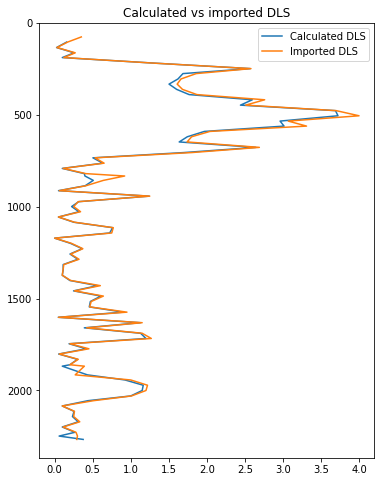

In [24]:
fig, ax = plt.subplots(figsize=(6,8), nrows=1, ncols=1)

ax.plot(dev.DL, dev['MD[m]'])
ax.plot(dev['Dogleg [deg/30m]'], dev['MD[m]'])
ax.set_ylim(dev['MD[m]'].values.max() + 100, 0)
ax.set_title('Calculated vs imported DLS')
labels = ['Calculated DLS', 'Imported DLS']
plt.legend(labels)

plt.show()

CF = 2 / DL * (Tan (DL / 2)) * 0.017453

The term 0.017453 converts degrees to radians.

In [25]:
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305


In [26]:
dev['CF'] = (2 / np.radians(dev['DL']) * np.tan(np.radians(dev['DL'])) / 2)
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001


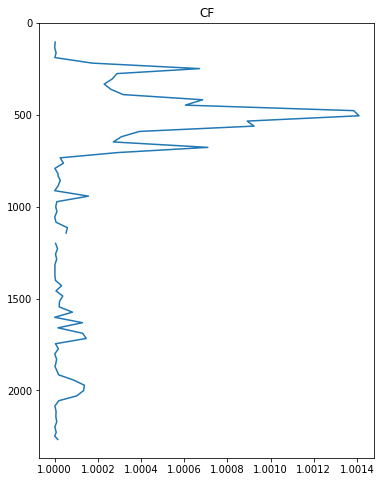

In [27]:
fig, ax = plt.subplots(figsize=(6,8), nrows=1, ncols=1)

ax.plot(dev.CF, dev['MD[m]'])
ax.set_ylim(dev['MD[m]'].values.max() + 100, 0)
ax.set_title('CF')
labels = ['CF']

plt.show()

North = SUM ((MD2 - MD1)*((Sin WD1 * Cos HAZ1 + Sin WD2 * Cos HAZ2) / 2) * CF)

In [28]:
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,0.0,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,0.0,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,0.1,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001


In [29]:
incl_uppers = dev['Inc[rad]'][:-1] 
incl_lowers = dev['Inc[rad]'][1:]
azi_uppers = dev['Azi[rad]'][:-1]
azi_lowers = dev['Azi[rad]'][1:]

In [30]:
sin_cos_inc_azi = (np.sin(incl_uppers) * np.cos(azi_uppers) + np.sin(incl_lowers) * np.cos(azi_lowers)) / 2

In [31]:
dev['northing[m]'] = dev['delta_MD[m]'].values * sin_cos_inc_azi * dev['CF']
dev['northing[m]'] = dev['northing[m]'].cumsum()
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],...,delta_Azi[deg],delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF,northing[m]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,...,10.01,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003,0.421187
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,...,-1.61,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000,0.869624
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,...,-9.20,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007,1.417744
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,...,-0.39,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001,1.956557


East = SUM ((MD2 - MD1) * ((Sin WD1 * Sin HAZ1 + Sin WD2 * Sin HAZ2) / 2) * CF)

In [32]:
sin_sin_inc_azi = (np.sin(incl_uppers) * np.sin(azi_uppers) + np.sin(incl_lowers) * np.sin(azi_lowers)) / 2

In [33]:
dev['easting[m]'] = dev['delta_MD[m]'] * sin_sin_inc_azi * dev['CF']
dev['easting[m]'] = dev['easting[m]'].cumsum()
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],...,delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF,northing[m],easting[m]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,...,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003,0.421187,0.130379
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,...,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000,0.869624,0.255501
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,...,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007,1.417744,0.316885
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,...,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001,1.956557,0.373517


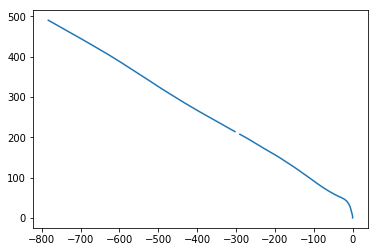

In [34]:
plt.plot(dev['easting[m]'], dev['northing[m]'])

TVD = SUM (((MD2 - MD1) * (Cos WD2 + Cos WD1) / 2) * CF)

In [35]:
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],...,delta_TVD[m],delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF,northing[m],easting[m]
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,...,28.06,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003,0.421187,0.130379
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,...,29.64,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000,0.869624,0.255501
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,...,28.73,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007,1.417744,0.316885
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,...,25.86,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001,1.956557,0.373517


In [36]:
incl_uppers = dev['Inc[rad]'].values[:-1]
incl_lowers = dev['Inc[rad]'].values[1:]

In [37]:
tvd_temp = dev['delta_MD[m]'].values[1:] * (np.cos(incl_lowers) + np.cos(incl_uppers)) / 2 * dev['CF'].values[1:]
dev['TVD'] = np.insert(tvd_temp, 0, np.nan)
dev['TVD'] = dev['TVD'].cumsum()
dev.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],...,delta_North[m],delta_East[m],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL,CF,northing[m],easting[m],TVD
0,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.015708,0.125489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.015708,0.300197,28.07,...,0.43,0.10,-0.18,0.000000,0.174707,0.157030,1.000003,0.421187,0.130379,28.066607
2,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.015708,0.272097,29.64,...,0.45,0.13,-0.14,0.000000,-0.028100,0.025288,1.000000,0.869624,0.255501,57.702953
3,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.019199,0.111527,28.73,...,0.49,0.09,0.24,0.003491,-0.160570,0.255866,1.000007,1.417744,0.316885,86.428724
4,188.60,1.2,6.00,188.58,2.48,0.45,0.12,0.020944,0.104720,25.87,...,0.52,0.06,-0.15,0.001745,-0.006807,0.100305,1.000001,1.956557,0.373517,112.293530


Text(0.5, 1.0, 'TVD plot')

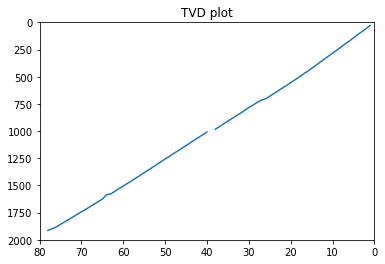

In [38]:
plt.plot(dev['TVD'])
plt.xlim(80, 0)
plt.ylim(2000, 0)
plt.title('TVD plot')

In [39]:
dev.columns

Index(['MD[m]', 'Inc[deg]', 'Azi[deg]', 'TVD[m]', 'North[m]', 'East[m]',
       'Dogleg [deg/30m]', 'Inc[rad]', 'Azi[rad]', 'delta_MD[m]',
       'delta_Inc[deg]', 'delta_Azi[deg]', 'delta_TVD[m]', 'delta_North[m]',
       'delta_East[m]', 'delta_Dogleg [deg/30m]', 'delta_Inc[rad]',
       'delta_Azi[rad]', 'DL', 'CF', 'northing[m]', 'easting[m]', 'TVD'],
      dtype='object')

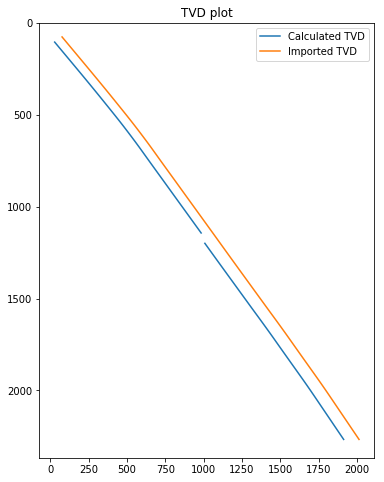

In [40]:
fig, ax = plt.subplots(figsize=(6,8), nrows=1, ncols=1)

ax.plot(dev.TVD, dev['MD[m]'])
ax.plot(dev['TVD[m]'], dev['MD[m]'])
ax.set_ylim(dev['MD[m]'].values.max() + 100, 0)
ax.set_title('TVD plot')
labels = ['Calculated TVD', 'Imported TVD']
plt.legend(labels)

plt.show()

    1: DL = Arccos (Cos (WD2 - WD1) - Sin WD1 * Sin WD2 * (1 - Cos (HAZ2 - HAZ1)))
    2: CF = 2 / DL * (Tan (DL / 2)) * 0.017 453
    3: North = SUM ((MD2 - MD1)*((Sin WD1 * Cos HAZ1 + Sin WD2 * Cos HAZ2) / 2) * CF)
    4: East = SUM ((MD2 - MD1) * ((Sin WD1 * Sin HAZ1 + Sin WD2 * Sin HAZ2) / 2) * CF)
    5: TVD = SUM (((MD2 - MD1) * (Cos WD2 + Cos WD1) / 2) * CF)

    DL = dog leg severity (degrees)
    CF = curvature factor (radians)
    East = easterly displacement (feet or meters) - negative = West
    HAZ1 = hole azimuth at top of course (degrees)
    HAZ2 = hole azimuth at bottom of course (degrees)
    MD1 = measured depth at top of course (feet or meters)
    MD2 = measured depth at bottom of course (feet or meters)
    North = northerly displacement (feet or meters) - negative = South
    TVD = true vertical depth (feet or meters)
    WD1 = well deviation at top of course (degrees)
    WD2 = well deviation at bottom of course (degrees)

    Depth = 3500 ft
    Inclination = 15 degree (I1)
    Azimuth = 20degree (Az1)

    Depth = 3600 ft
    Inclination = 25 degree (I2)
    Azimuth = 45 degree (Az2)

In [41]:
md_test = np.array([3500, 3600])
incl_test = np.array([15, 25])
azi_test = np.array([20, 45])

In [42]:
import numpy as np

def min_curve_method(md, inc, azi):
    """
    Calculate TVD using minimum curvature method.
    
    Parameters
    ----------
    md: float, measured depth in m or ft
    inc: float, well deviation in degrees
    azi: float, well azimuth in degrees
                
    Returns
    -------
    Deviation converted to TVD, easting, northing
        TVD in m or feet,
        northing in m or feet,
        easting in m or feet
    Dogleg
        Dogleg angle in degrees
        
    ToDo
    ----
    Implement DLS
        Dogleg in degrees/100ft or degrees/30m
        Requires `.get_header()` ouput
    """
    # inputs are array-like
    try:
        md = np.array(md) + 0
    except TypeError:
        raise TypeError('md must be array-like')

    try:
        inc = np.array(inc) + 0
    except TypeError:
        raise TypeError('inc must be array-like')

    try:
        azi = np.array(azi) + 0
    except TypeError:
        raise TypeError('azi must be array-like')

    # inputs are same length
    try:
        1 / (md.shape == inc.shape == azi.shape)
    except ZeroDivisionError:
        raise ZeroDivisionError('md, incl and azi must be of same length')

    # inputs dtype are int or float
    try:
        md += 0
    except TypeError:
        raise TypeError('md array must of dtype int or float')

    try:
        inc += 0
    except TypeError:
        raise TypeError('inc array must of dtype int or float')

    try:
        azi += 0
    except TypeError:
        raise TypeError('azi array must of dtype int or float')

    # md array increases strictly at each step
    try:
        1 / bool(np.all(md[1:] > md[:-1]))
    except ZeroDivisionError:
        raise ZeroDivisionError('md must have strictly increasing values')

    # get units
    #norm = 100 if units == 'm' else 30
        
    # convert degrees to radians for numpy functions
    azi_r = np.deg2rad(azi)
    inc_r = np.deg2rad(inc)
    
    # extract upper and lower survey stations
    md_upper, md_lower = md[:-1], md[1:]
    incl_upper, incl_lower = inc_r[:-1], inc_r[1:]
    azi_upper, azi_lower = azi_r[:-1], azi_r[1:]
    
    # calculate dogleg
    dl = np.rad2deg(np.arccos(np.cos(incl_lower - incl_upper) - 
                              (np.sin(incl_upper) * np.sin(incl_lower) *
                               (1 - np.cos(azi_lower - azi_upper)))))
    
    # calculate dls
    #dls = (dl * (norm / md_lower - md_upper))
    
    # ratio factor, correct for dl == 0 values
    rf = 2 / np.deg2rad(dl) * np.tan(np.deg2rad(dl)/2)
    rf = np.where(dl == 0., 1, rf)
    
    northing = np.cumsum((md_lower - md_upper) / 2 * (np.sin(incl_upper) * np.cos(azi_upper) 
                                            + np.sin(incl_lower) * np.cos(azi_lower)) * rf)
    
    easting = np.cumsum((md_lower - md_upper) / 2 * (np.sin(incl_upper) * np.sin(azi_upper) 
                                            + np.sin(incl_lower) * np.sin(azi_lower)) * rf)
    
    tvd = np.cumsum((md_lower - md_upper) / 2 * (np.cos(incl_upper) + np.cos(incl_lower)) * rf)
    
    return tvd, northing, easting

In [43]:
min_curve_method(md_test, incl_test, azi_test)

(array([94.01234323]), array([27.21832857]), array([19.45077375]))

In [44]:
tvd, northing, easting = min_curve_method(dev['MD[m]'].values, dev['Inc[deg]'].values, dev['Azi[deg]'].values)

/home/geodev/anaconda3/envs/wellpath/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/home/geodev/anaconda3/envs/wellpath/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in multiply


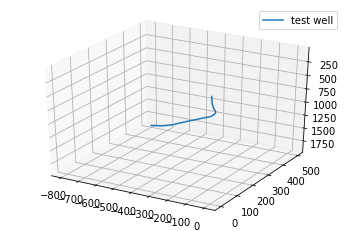

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(easting, northing, tvd, label='test well')
ax.invert_zaxis()
ax.legend()
plt.show()

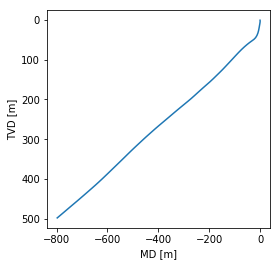

In [46]:
fig = plt.figure(figsize=(4,4))
plt.plot(easting, northing)

plt.gca().invert_yaxis()

plt.xlabel('MD [m]')
plt.ylabel('TVD [m]')
plt.show()